# INTRODUCTION

## Libraries

In [4]:
import os
import datetime
import IPython

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE

from keras import layers, models, Sequential, regularizers
from keras.layers import SimpleRNN, Dense, Dropout, Embedding, LSTM, GRU
from keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.regularizers import L1, L2, L1L2

import keras_tuner as kt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Import data & column groups

In [5]:
DAILY_DATA_PATH = "data.v3/daily" 

df = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7',
             'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7',
             'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7',]

# Drop lag columns and date from data
df = df.drop(columns=lag_cols + ['date'])

print("Unique data types in df", df.dtypes.value_counts(), sep = '\n')

# Identify categorical and numeric columns in df
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include = ['float64', 'float32', 'int32', 'int64']).columns.tolist()
num_features = df.shape[1]

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")
print(f"\nAll columns accounted for: {len(categorical_cols) + len(numeric_cols) == num_features}")

Unique data types in df
float64    40
object     11
int64       7
float32     4
int32       2
Name: count, dtype: int64

Categorical columns: ['covid', 'month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter']
Numeric columns: ['ordinal_date', 'year', 'day_of_month', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'flights_cancel', 'flights_delay', 'flights_ontime', 'flights_arr', 'flights_dep', 'flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E', 'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E', 'flights_arr_cancel', 'flights_arr_delay', 'flights_arr_ontime', 'flights_dep_cancel', 'flights_dep_delay', 'flights_dep_ontime', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed

## Split data sequentially 70/20/10

In [6]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# print data shapes
print(f"Train data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Test data shape: {test_df.shape}")

Train data shape: (1179, 64)
Validation data shape: (337, 64)
Test data shape: (169, 64)


## Preprocess data for recurrent neural network (RNN)

In [7]:
# Fit transformers to the training data
scaler = StandardScaler()
scaler.fit(train_df[numeric_cols])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Some observed holidays may not be in the training data
ohe.fit(train_df[categorical_cols])
ohe_column_names = ohe.get_feature_names_out(input_features=categorical_cols)

def preprocess(data):
    scaled_features = scaler.transform(data[numeric_cols])
    encoded_features = ohe.transform(data[categorical_cols])
    processed_data = pd.DataFrame(np.concatenate([scaled_features, encoded_features], axis=1),
                                  columns = numeric_cols + list(ohe_column_names))
    return processed_data

train_df = preprocess(train_df)
val_df = preprocess(val_df)
test_df = preprocess(test_df)

print(f"\nNumber of columns before preprocessing: {num_features}")
print(f"Number of features after preprocessing: {train_df.shape[1]}")


Number of columns before preprocessing: 64
Number of features after preprocessing: 105


## WindowGenerator
The `WindowGenerator` class stores the train, validate, and test sets (Pandas DataFrames), and it handles indexes and offsets for windowing. Several methods are added to this class after its creation. When the `split_window` method is added, the class will split data windows into separate tensors for features and labels. The `plot` method, produces a plot of an example batch showing inputs, labels, and predictions. The `make_dataset` method creates TensorFlow timeseries datastes that are batched, windowed, and ready for use in modeling.

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

class WindowGenerator():
  """
  A class to hold train, validate, and test sets and manage windowing and conversion to TensorFlow time series datasets

  Attributes:
    input_width (int): The number of time steps to include in the input window
    label_width (int): The number of time steps to include in the label window
    shift (int): The number of time steps to shift the label window to create the next input window
    train_df (pd.DataFrame): The training data
    val_df (pd.DataFrame): The validation data
    test_df (pd.DataFrame): The test data
    label_columns (list): The columns to predict

  Methods:
    __init__(input_width, label_width, shift, train_df, val_df, test_df, label_columns)
    __repr__() # Return a string representation of the window
  """

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
               
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Instantiate WindowGenerators

In [9]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['flights_ontime'])

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                        label_columns=['flights_ontime'])

## Add split_window method

In [10]:
def split_window(self, features):
  """
  Given a window of features, the method splits the features into inputs and labels

  Args:
  features: A window of features

  Returns:
  inputs: A window of input features
  labels: A window of label features
  """

  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

# Add the method to the class
WindowGenerator.split_window = split_window

Demonstrate split_window on an example batch of 3 windows

In [11]:
# Stack three slices, the length of the total window. This creates an example batch of 3 windows, each of 7-timesteps and 105 features
example_batch = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_batch)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_batch.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 105)
Inputs shape: (3, 6, 105)
Labels shape: (3, 1, 1)


Create an "example" attribute for w2 and add the example batch inputs and labels

In [12]:
w2.example = example_inputs, example_labels

## Add plot method
The plot method shows inputs, labels, and predictions for an example batch. Initially, we add an example attribute directly to the w2 example. Below, we add an example method 

In [13]:
def plot(self, model=None, plot_col='flights_ontime', max_subplots=3):
  """
  Given a model and a column to plot, the method plots the inputs, labels, and predictions

  Args:
  model: A trained model
  plot_col: The column to plot
  max_subplots: The maximum number of subplots to display

  Returns:
  """

  inputs, labels = self.example
  
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')

    # Plot inputs
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    # Plot labels
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    # Plot predictions
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')

# Add the method to the class
WindowGenerator.plot = plot

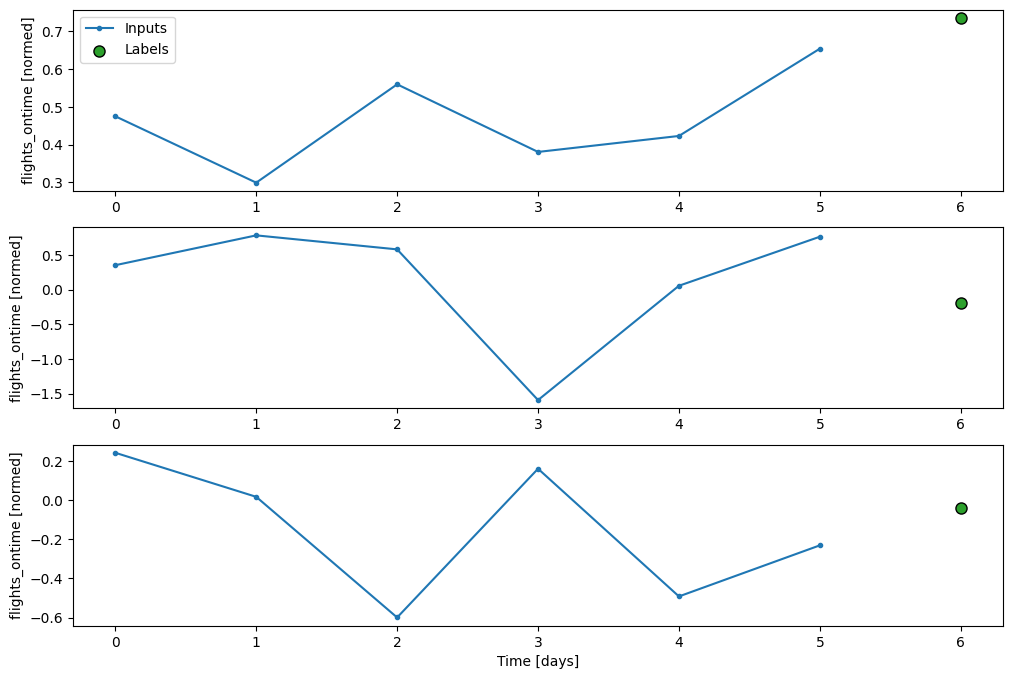

In [14]:
w2.plot()

## Add make_dataset

The make_dataset method creates TensorFlow timeseries datasets from the data objects held by WindowGenerator. The split_window function is mapped over the windows of the TensorFlow datasets, creating inputs and labels for each window. 

In [15]:
def make_dataset(self,data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

# Add the method to the class
WindowGenerator.make_dataset = make_dataset

# Add properties to datasets within WindowGenerator
Add properties for accessing the train, validation, and test datasets as TensorFlow timeseries datasets created by make_dataset. The `@property` decorator is used to define getter methods for properties of a class, allowing access to the result of a method as an attribute of the class. Properties are a special kind of attribute that are accessed like attributes but they execute class methods when getting, setting, or deleting the property value.

In [16]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

The `element_spec` attribute 

Inspect an element of a tf.data.Dataset of w2 using the element_spec attribute

In [17]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 105), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

 Iterating over a tf timeseries dataset produced and held within a WindowGenerator instance, e.g. `w2.train` produces batches of data, where each batch has an input tensor and a labels tensor.

In [18]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time steps, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time steps, features): {example_labels.shape}')

Inputs shape (batch, time steps, features): (32, 6, 105)
Labels shape (batch, time steps, features): (32, 1, 1)


## single_step_window

In [19]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['flights_ontime'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['flights_ontime']

Like for w2.train, iterating over single_step_window.train produces batches of two Tensors, inputs and labels. w2 used 6 steps in the input and single_step_window uses 1.

In [20]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 105)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline
The `Baseline` class inherits from `keras.Model` and uses the current value of a label to predict a label one step (one day) into the future, ignoring all other information. We hope to beat this model with a LSTM recurrent network that considers current and recent values of the label and other features.

In [21]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

The baseline model of using the previous day's ontime flights to predict the next day's ontime flights produced MSE and MAE validation set scores of 2.51 and 1.36 respectively. Again, we'll try to beat this with a LSTM recurrent network.

In [22]:
baseline = Baseline(label_index=column_indices['flights_ontime'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, verbose=0)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

print("Validation performance: ", val_performance)
print("Test performance: ", performance)


Validation performance:  {'Baseline': [0.49093031883239746, 0.4568639397621155]}
Test performance:  {'Baseline': [0.7780312299728394, 0.5610708594322205]}


Below we create a wider window of 28 days (4 weeks) for visually evalating the baseline model. 

In [23]:
wide_window = WindowGenerator(
    input_width=28, label_width=28, shift=1,
    label_columns=['flights_ontime'])

wide_window

Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Label column name(s): ['flights_ontime']

In [24]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 28, 105)
Output shape: (32, 28, 1)


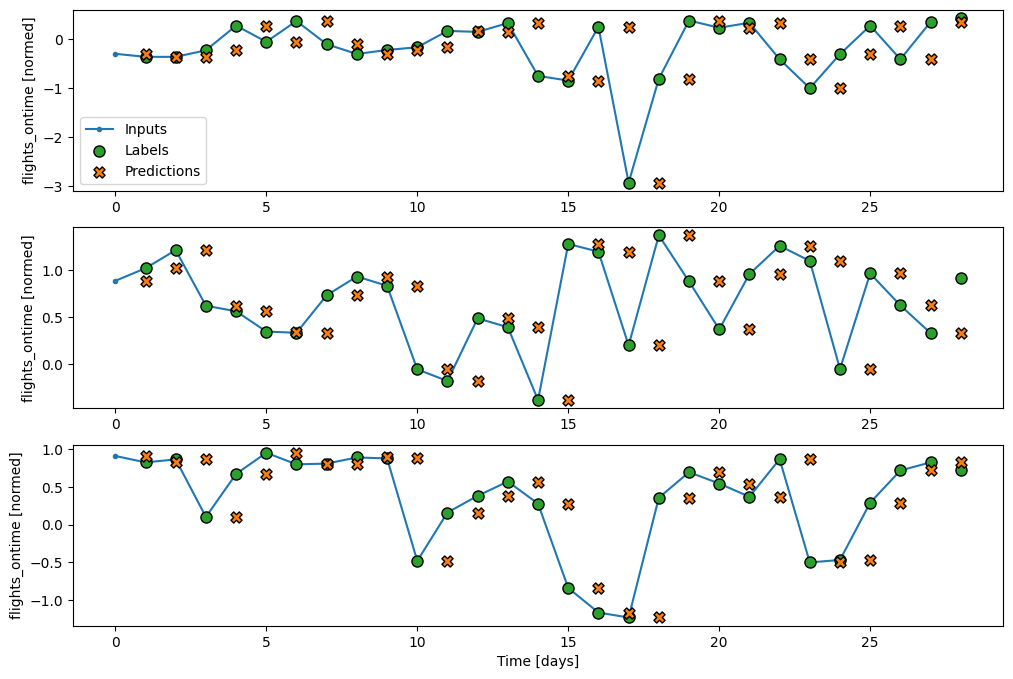

In [25]:
wide_window.plot(baseline)

In [26]:
wide_window.example[0]

<tf.Tensor: shape=(32, 28, 105), dtype=float32, numpy=
array([[[ 0.7462953 ,  0.35168898, -0.763517  , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.7492334 ,  0.35168898, -0.650343  , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.75217164,  0.35168898, -0.5371689 , ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [ 0.81974953,  0.35168898, -1.3293874 , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.8226877 ,  0.35168898, -1.2162133 , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.8256259 ,  0.35168898, -1.1030393 , ...,  0.        ,
          1.        ,  0.        ]],

       [[ 1.5954266 ,  1.3580999 ,  1.0472682 , ...,  0.        ,
          1.        ,  0.        ],
        [ 1.5983647 ,  1.3580999 ,  1.1604422 , ...,  0.        ,
          1.        ,  0.        ],
        [ 1.6013029 ,  1.3580999 ,  1.2736163 , ...,  0.        ,
          1.        ,  0.        ],
        ...,

# Linear Model

In [27]:
linear = Sequential([Dense(units=1)])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 105)
Output shape: (32, 1, 1)


In [28]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss='mean_squared_error',
                optimizer=Adam(),
                metrics=['mean_absolute_error'])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [48]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)

Epoch 1/20
37/37 [==============================] - 0s 3ms/step - loss: 0.4402 - mean_absolute_error: 0.4749 - val_loss: 0.4698 - val_mean_absolute_error: 0.5184
Epoch 2/20
37/37 [==============================] - 0s 1ms/step - loss: 0.4339 - mean_absolute_error: 0.4662 - val_loss: 0.4509 - val_mean_absolute_error: 0.5137
Epoch 3/20
37/37 [==============================] - 0s 1ms/step - loss: 0.4285 - mean_absolute_error: 0.4642 - val_loss: 0.4280 - val_mean_absolute_error: 0.4897
Epoch 4/20
37/37 [==============================] - 0s 1ms/step - loss: 0.4262 - mean_absolute_error: 0.4644 - val_loss: 0.4175 - val_mean_absolute_error: 0.4798
Epoch 5/20
37/37 [==============================] - 0s 1ms/step - loss: 0.4253 - mean_absolute_error: 0.4622 - val_loss: 0.4109 - val_mean_absolute_error: 0.4713
Epoch 6/20
37/37 [==============================] - 0s 1ms/step - loss: 0.4217 - mean_absolute_error: 0.4612 - val_loss: 0.4056 - val_mean_absolute_error: 0.4630
Epoch 7/20
37/37 [==========

In [47]:
y_pred = linear.predict(single_step_window.val)
y_true = np.concatenate([y for x, y in single_step_window.val], axis=0)

y_pred = y_pred.flatten()
y_true = y_true.flatten()

linear_mae = mean_absolute_error(y_true, y_pred)
linear_mse = mean_squared_error(y_true, y_pred)

print("Validation MAE: ", linear_mae)
print("Validation MSE: ", linear_mse)

11/11 [==============================] - 0s 456us/step
Validation MAE:  0.6412493
Validation MSE:  0.72008526


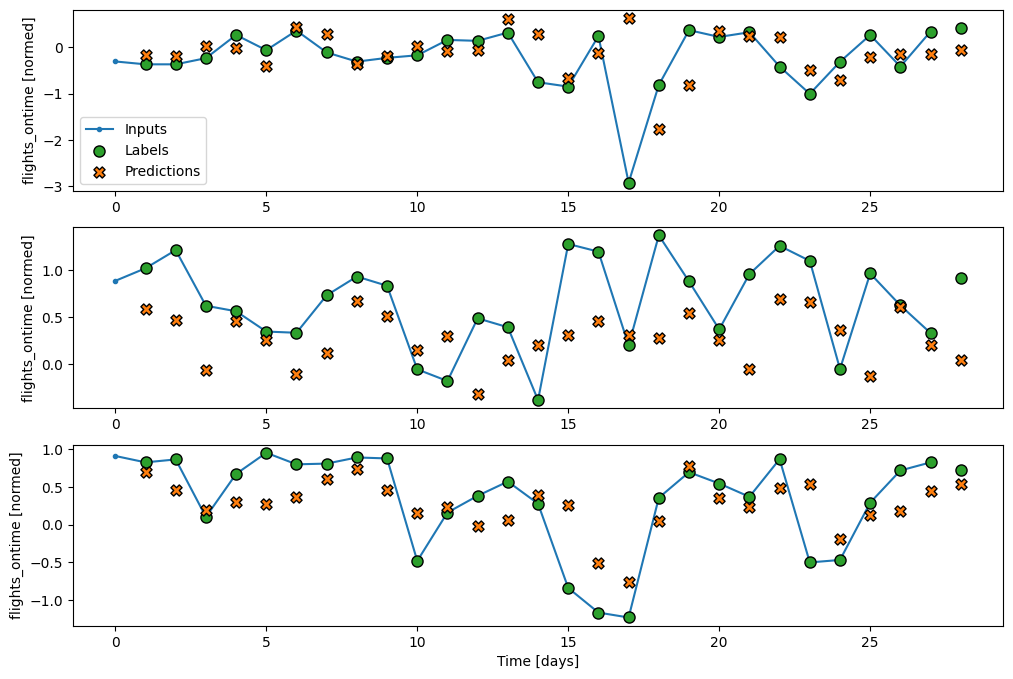

In [30]:
wide_window.plot(linear)

# LSTM Model

In [31]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [32]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 28, 105)
Output shape: (32, 28, 1)


In [33]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.4580 - mean_absolute_error: 0.4788


In [46]:
# Performance
y_pred = lstm_model.predict(wide_window.val)
y_true = np.concatenate([y for x, y in wide_window.val], axis=0)

y_pred = y_pred.flatten()
y_true = y_true.flatten()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.60
Mean Squared Error: 0.67


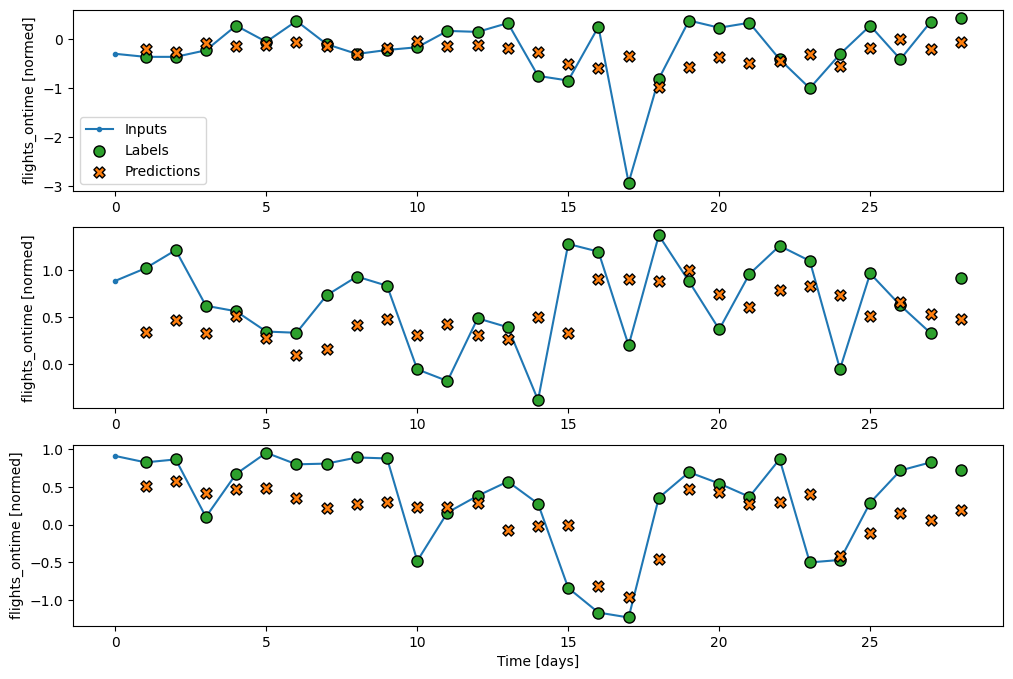

In [34]:
wide_window.plot(lstm_model)

## LSTM Hypermodel

In [36]:
def build_model(hp):
    n_neurons = hp.Int('n_neurons', min_value=2, max_value=32, step=2)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)


    model = tf.keras.models.Sequential()
    model.add(LSTM(units=n_neurons, return_sequences=True))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                    loss='mean_squared_error',
                    metrics=['mean_absolute_error'])
    return model

In [37]:
LSTM_tuner_BO = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=5,
    num_initial_points=2,
    overwrite=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

LSTM_tuner_BO.search(wide_window.train, 
                     epochs=MAX_EPOCHS, 
                     validation_data=wide_window.val, 
                     callbacks=[early_stopping]) 

Trial 5 Complete [00h 00m 02s]
val_loss: 0.3729272186756134

Best val_loss So Far: 0.3615141212940216
Total elapsed time: 00h 00m 15s


In [39]:
best_hps = LSTM_tuner_BO.get_best_hyperparameters(num_trials = 1)[0]
lstm_model_tuned = LSTM_tuner_BO.hypermodel.build(best_hps)

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = lstm_model_tuned.fit(wide_window.train,
                         epochs=MAX_EPOCHS,
                         validation_data=wide_window.val)


Epoch 1/20
36/36 [==============================] - 1s 10ms/step - loss: 0.8350 - mean_absolute_error: 0.7032 - val_loss: 0.4917 - val_mean_absolute_error: 0.4541
Epoch 2/20
36/36 [==============================] - 0s 4ms/step - loss: 0.6336 - mean_absolute_error: 0.5932 - val_loss: 0.4198 - val_mean_absolute_error: 0.4143
Epoch 3/20
36/36 [==============================] - 0s 4ms/step - loss: 0.5599 - mean_absolute_error: 0.5528 - val_loss: 0.3952 - val_mean_absolute_error: 0.4268
Epoch 4/20
36/36 [==============================] - 0s 4ms/step - loss: 0.5318 - mean_absolute_error: 0.5363 - val_loss: 0.3836 - val_mean_absolute_error: 0.4218
Epoch 5/20
36/36 [==============================] - 0s 4ms/step - loss: 0.5044 - mean_absolute_error: 0.5157 - val_loss: 0.4136 - val_mean_absolute_error: 0.4407
Epoch 6/20
36/36 [==============================] - 0s 4ms/step - loss: 0.4845 - mean_absolute_error: 0.5077 - val_loss: 0.4555 - val_mean_absolute_error: 0.4304
Epoch 7/20
36/36 [=========

In [43]:
# Print the best hyperparameters
print(f"""Best Hyperparameters:
n_neurons: {best_hps.get('n_neurons')}
learning_rate: {best_hps.get('learning_rate')}
dropout_rate: {best_hps.get('dropout_rate')}
""")

Best Hyperparameters:
n_neurons: 2
learning_rate: 0.01
dropout_rate: 0.30000000000000004



In [45]:
y_pred = lstm_model_tuned.predict(wide_window.val)
y_true = np.concatenate([y for x, y in wide_window.val], axis=0)

y_pred = y_pred.flatten()
y_true = y_true.flatten()

lstm_model_tuned_val_mse = mean_squared_error(y_true, y_pred)
lstm_model_tuned_val_mae = mean_absolute_error(y_true, y_pred)

print(f"""Validation Metrics:
      - Validation MAE: {lstm_model_tuned_val_mae}
      - Validation MSE: {lstm_model_tuned_val_mse}
      """)

10/10 [==============================] - 0s 1ms/step
Validation Metrics:
      - Validation MAE: 0.5868037939071655
      - Validation MSE: 0.7171504497528076
      


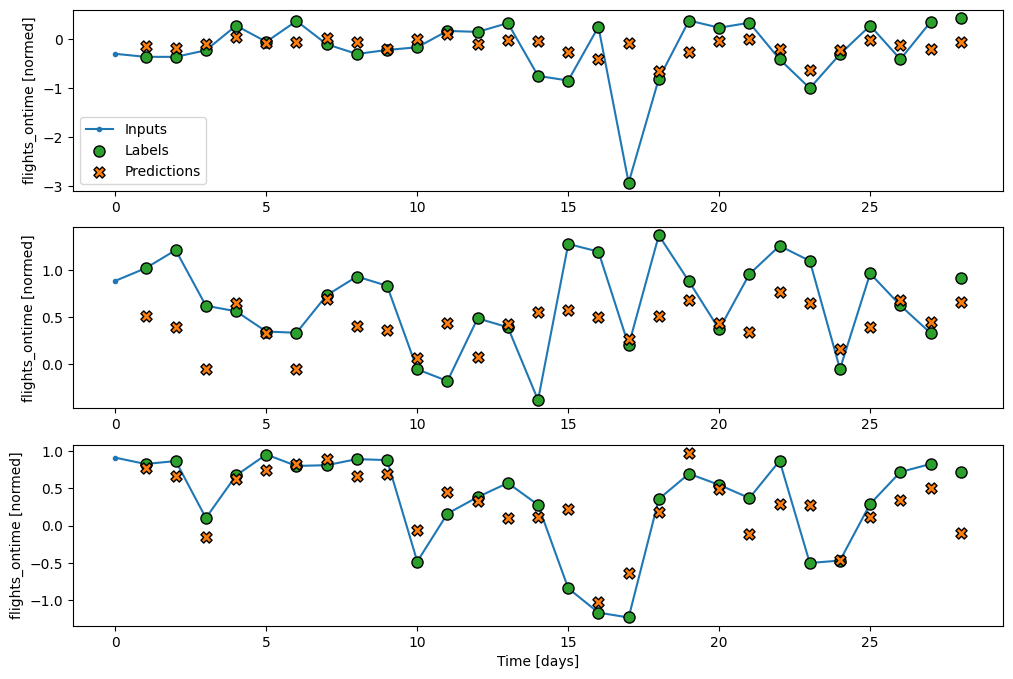

In [40]:
wide_window.plot(lstm_model_tuned)